# BA820 - Milestone 3: Integrated Analysis & Synergy
**Section A1, Team 1**  
**Team Members:** Anton Falk, Jesse Kinsmann, Adam Schuler  
**Date:** February 2026

---

This notebook integrates our three M2 analyses:
- **Anton's Question & Analysis:** Core vs Specialty Colors — clustering colors by co-occurrence, PCA
- **Jesse's Question & Analysis:** Palette Clustering — grouping paintings by full color profile
- **Adam's Question & Analysis:** Color Substitution — association rules, exclusion patterns, temporal analysis

**M2 Feedback addressed:** Our M2 clustering used KMeans (euclidean distance) on binary color features. The feedback correctly identified this as inappropriate for categorical data. For M3 we kept the KElbowVisualizer with KMeans to select K (same workflow as M2), then switched the actual clustering step to KModes which uses hamming distance and is designed for binary/categorical variables.

## Part 0: Setup

In [ ]:
# Gemini: "our prof's feedback said KMeans with euclidean distance is wrong for binary columns.
#   we have 18 color columns that are all 0/1. Does kmodes
#   work the same way as KMeans or if the whole pipeline changes.
#   like can I still do: model = KModes(n_clusters=k); model.fit_predict(data)?"
#   -> yes same API. KModes uses hamming distance (counts how many columns differ) instead of
#   euclidean. pip install kmodes, then from kmodes.kmodes import KModes. fit_predict works the same
!pip install kmodes -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from kmodes.kmodes import KModes
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=17d9X4zUbU4uPD_oEqb0hlnMexbjZcpeR')

color_cols = [c for c in df.columns if df[c].dtype == bool]
print(f"Dataset: {df.shape[0]} paintings, {len(color_cols)} colors")
df.head()

Dataset: 403 paintings, 18 colors


,painting_index,img_src,painting_title,season,episode,num_colors,youtube_src,colors,color_hex,Black_Gesso,...,Liquid_Clear,Midnight_Black,Phthalo_Blue,Phthalo_Green,Prussian_Blue,Sap_Green,Titanium_White,Van_Dyke_Brown,Yellow_Ochre,Alizarin_Crimson
0,282,https://www.twoinchbrush.com/images/painting28...,A Walk in the Woods,1,1,8,https://www.youtube.com/embed/oh5p5f5_-7A,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
1,283,https://www.twoinchbrush.com/images/painting28...,Mt. McKinley,1,2,8,https://www.youtube.com/embed/RInDWhYceLU,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True
2,284,https://www.twoinchbrush.com/images/painting28...,Ebony Sunset,1,3,9,https://www.youtube.com/embed/UOziR7PoVco,"['Alizarin Crimson', 'Black Gesso', 'Bright Re...","['#4E1500', '#000000', '#DB0000', '#FFEC00', '...",True,...,False,False,False,True,True,True,True,True,False,True
3,285,https://www.twoinchbrush.com/images/painting28...,Winter Mist,1,4,3,https://www.youtube.com/embed/0pwoixRikn4,"['Prussian Blue', 'Titanium White', 'Van Dyke ...","['#021E44', '#FFFFFF', '#221B15']",False,...,False,False,False,False,True,False,True,True,False,False
4,286,https://www.twoinchbrush.com/images/painting28...,Quiet Stream,1,5,8,https://www.youtube.com/embed/DFSIQNjKRfk,"['Alizarin Crimson', 'Bright Red', 'Cadmium Ye...","['#4E1500', '#DB0000', '#FFEC00', '#102E3C', '...",False,...,False,False,False,True,True,True,True,True,False,True


## Part 1: Shared Preprocessing

Unified theme dictionary merged from all three M2 notebooks into one multi-label system.

In [ ]:
# Unified theme keywords merged from all three M2 notebooks
theme_keywords = {
    "winter": ["winter", "snow", "frost", "cold", "ice", "frozen", "snowy"],
    "mountain": ["mountain", "mountains", "peak", "summit", "ridge", "alpine"],
    "water": ["lake", "river", "stream", "ocean", "sea", "waterfall", "pond", "creek", "falls"],
    "cabin": ["cabin", "barn", "house", "cottage", "mill"],
    "sunset": ["sunset", "sunrise", "dawn", "dusk", "evening", "sky", "glow"],
    "forest": ["forest", "woods", "trees"],
    "field": ["meadow", "field", "prairie", "hills"],
    "autumn": ["autumn", "fall"]
}

def assign_themes(title):
    title = title.lower()
    tags = {}
    for theme, keywords in theme_keywords.items():
        tags[f"theme_{theme}"] = any(word in title for word in keywords)
    return tags

theme_df = pd.DataFrame(df['painting_title'].apply(assign_themes).tolist())
df = pd.concat([df, theme_df], axis=1)

theme_cols = [c for c in df.columns if c.startswith('theme_')]
print("Theme counts:")
for col in theme_cols:
    count = df[col].sum()
    print(f"  {col}: {count} paintings ({round(count/len(df)*100, 1)}%)")

Theme counts:
  theme_winter: 56 paintings (13.9%)
  theme_mountain: 62 paintings (15.4%)
  theme_water: 86 paintings (21.3%)
  theme_cabin: 28 paintings (6.9%)
  theme_sunset: 28 paintings (6.9%)
  theme_forest: 18 paintings (4.5%)
  theme_field: 13 paintings (3.2%)
  theme_autumn: 45 paintings (11.2%)


In [ ]:
# Era column from Adam's temporal analysis
# Gemini: "adam split early vs late in M2 like:
#   early_df = df[df['season'] <= 10]
#   late_df = df[df['season'] >= 21]
#   but now we need a single column with 'early', 'middle', 'late' for every row.
#   i tried df['era'] = 'middle' then overwriting with loc but it felt sloppy, is there a vectorized way?"
#   -> nest np.where: np.where(season<=10, 'early', np.where(season>=21, 'late', 'middle'))
df['era'] = np.where(df['season'] <= 10, 'early',
            np.where(df['season'] >= 21, 'late', 'middle'))
print("Era breakdown:")
print(df['era'].value_counts())

Era breakdown:
era
late      143
early     130
middle    130
Name: count, dtype: int64


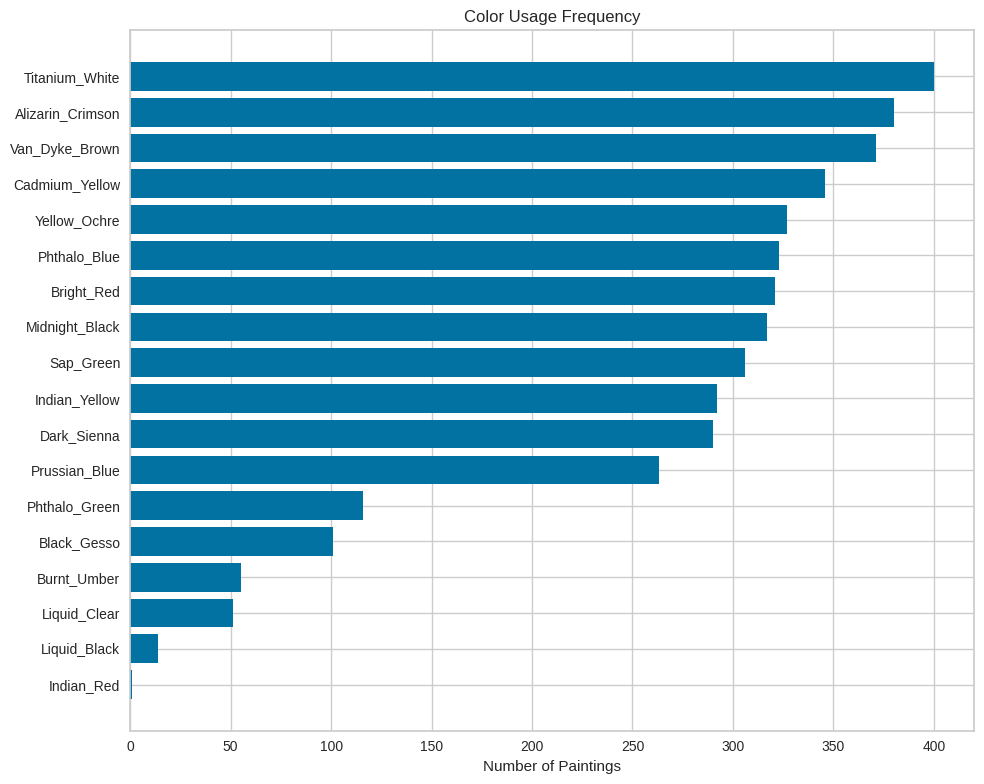

In [ ]:
# Color usage bar chart (from shared M2 EDA)
# Kept because the gap in this chart shows the core vs specialty split
color_usage = df[color_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 8))
colors_sorted = color_usage.sort_values()
plt.barh(range(len(colors_sorted)), colors_sorted.values)
plt.yticks(range(len(colors_sorted)), [c for c in colors_sorted.index])
plt.xlabel('Number of Paintings')
plt.title('Color Usage Frequency')
plt.tight_layout()
plt.show()

## Part 2: Shared EDA

EDA that all three of us ran independently in M2. Consolidated here to avoid redundancy.

In [ ]:
# Missing values check
print("Missing values:", df.isna().sum().sum())

# Basic dataset stats
print(f"\nDataset Overview")
print(f"Total paintings: {len(df)}")
print(f"Seasons: {df['season'].min()}-{df['season'].max()}")
print(f"Colors tracked: {len(color_cols)}")
print(f"Average colors per painting: {df['num_colors'].mean():.1f}")
print(f"\nColors per painting:")
print(f"  Min: {df['num_colors'].min()}")
print(f"  Max: {df['num_colors'].max()}")
print(f"  Median: {df['num_colors'].median()}")

Missing values: 0

Dataset Overview
Total paintings: 403
Seasons: 1-31
Colors tracked: 18
Average colors per painting: 10.6

Colors per painting:
  Min: 1
  Max: 15
  Median: 11.0


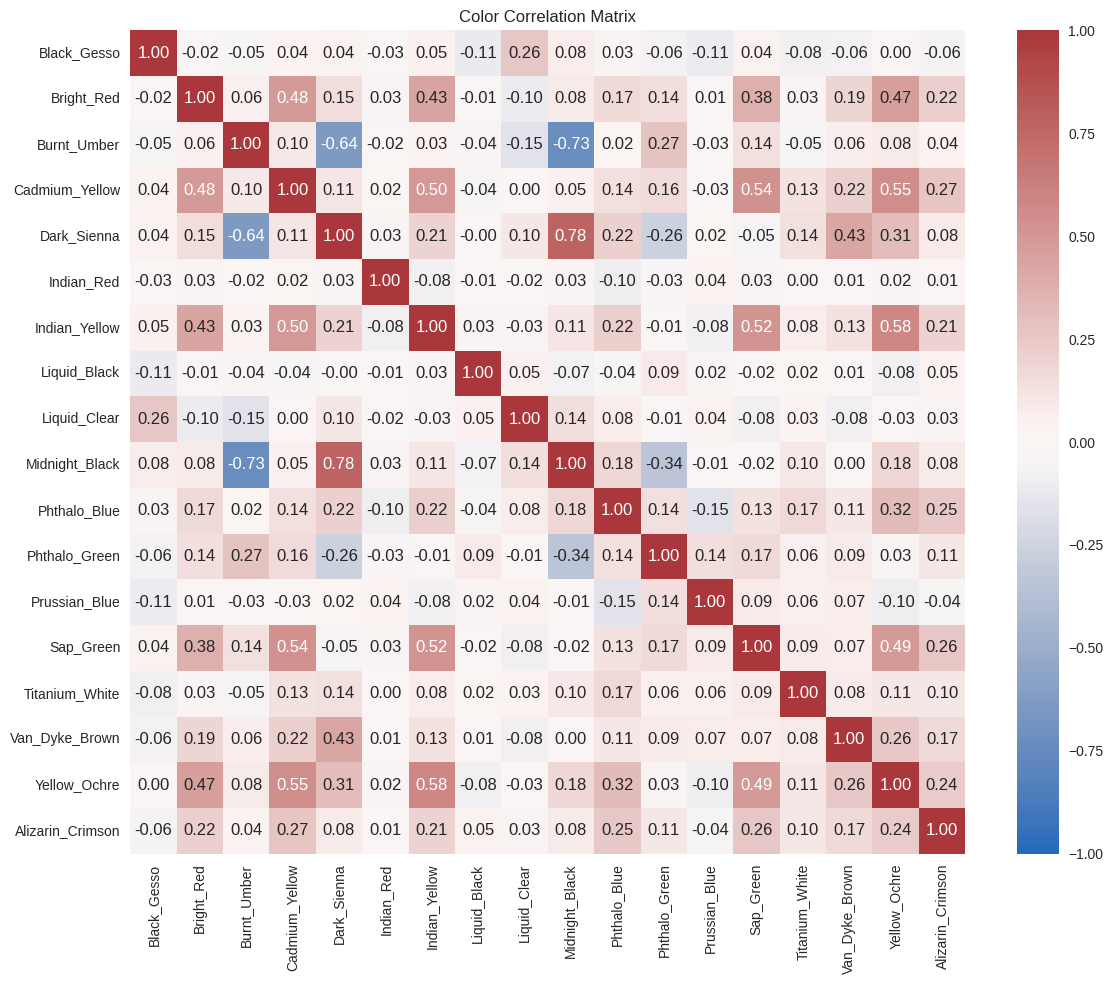

In [ ]:
# Correlation heatmap
color_corr = df[color_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(color_corr, annot=True, fmt='.2f', cmap='vlag', center=0, vmin=-1, vmax=1)
plt.title('Color Correlation Matrix')
plt.tight_layout()
plt.show()

Dark Sienna and Midnight Black correlate strongly (~0.78), Burnt Umber is negatively correlated with both. This is the era shift signal showing up in the correlation structure.

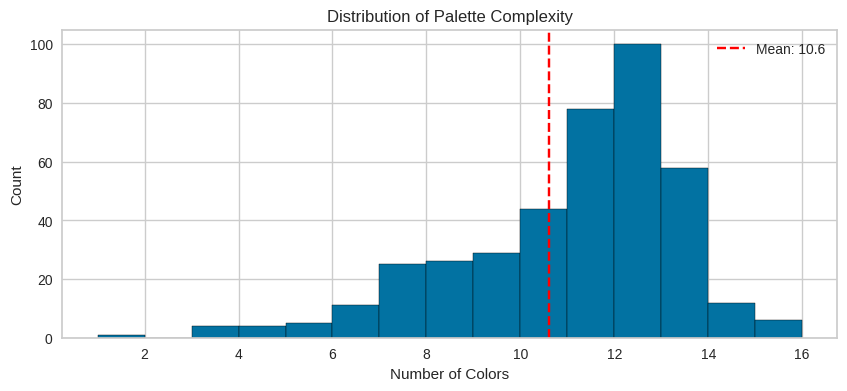

In [ ]:
# Palette complexity distribution
plt.figure(figsize=(10, 4))
plt.hist(df['num_colors'], bins=range(1, 17), edgecolor='black')
plt.axvline(df['num_colors'].mean(), color='red', linestyle='--', label=f"Mean: {round(df['num_colors'].mean(), 1)}")
plt.xlabel('Number of Colors')
plt.ylabel('Count')
plt.title('Distribution of Palette Complexity')
plt.legend()
plt.show()

In [ ]:
# Palette complexity breakdown
simple = len(df[df['num_colors'] <= 5])
medium = len(df[(df['num_colors'] > 5) & (df['num_colors'] <= 10)])
complex_p = len(df[df['num_colors'] > 10])

total_paints = len(df)
print("Paintings with: ")
print(f"  5 or less colors: {simple} ({round((simple/total_paints)*100, 2)}%)")
print(f"  6-10 colors: {medium} ({round((medium/total_paints)*100, 2)}%)")
print(f"  10+ colors: {complex_p} ({round((complex_p/total_paints)*100, 2)}%)")

Paintings with: 
  5 or less colors: 14 (3.47%)
  6-10 colors: 135 (33.5%)
  10+ colors: 254 (63.03%)


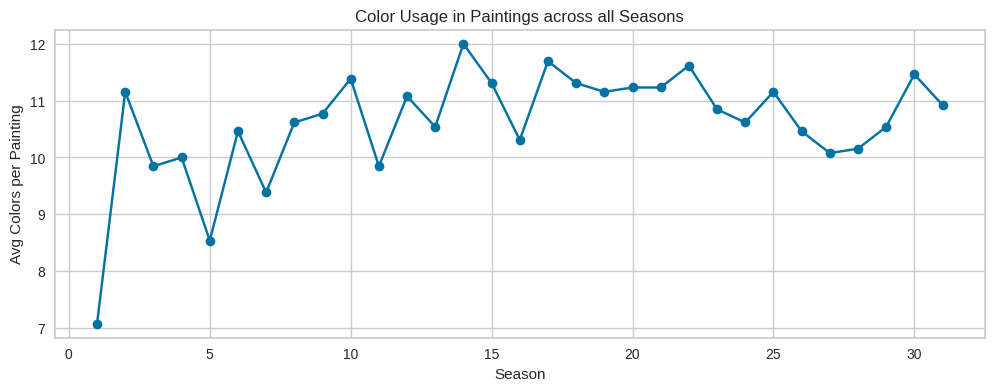

In [ ]:
# Average colors per painting over seasons
season_avg = df.groupby('season')['num_colors'].mean()

plt.figure(figsize=(12, 4))
plt.plot(season_avg.index, season_avg.values, marker='o')
plt.xlabel('Season')
plt.ylabel('Avg Colors per Painting')
plt.title('Color Usage in Paintings across all Seasons')
plt.show()

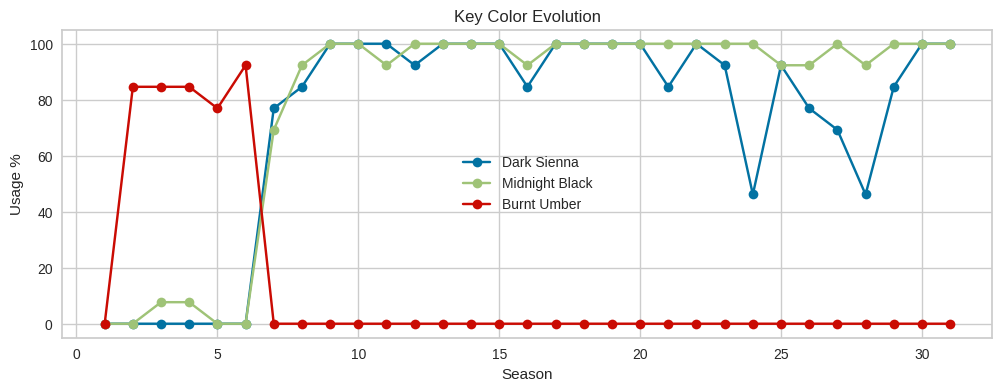

In [ ]:
# Key color evolution by season
key_colors = ['Dark_Sienna', 'Midnight_Black', 'Burnt_Umber']

plt.figure(figsize=(12, 4))
for color in key_colors:
    usage = df.groupby('season')[color].mean() * 100
    plt.plot(usage.index, usage.values, marker='o', label=color.replace('_', ' '))

plt.xlabel('Season')
plt.ylabel('Usage %')
plt.title('Key Color Evolution')
plt.legend()
plt.show()

Burnt Umber was around 85% in the first few seasons then drops to zero around season 7. Dark Sienna and Midnight Black jump up at the same time. This is the era shift that drives most of our downstream analyses.

In [ ]:
# Unique palettes
df['palette'] = df[color_cols].apply(lambda x: tuple(x), axis=1)
palette_counts = df['palette'].value_counts()

print(f"Total unique palettes: {len(palette_counts)}")
print(f"Paintings with unique palette: {sum(palette_counts == 1)}")
print(f"Most common palette appears: {palette_counts.iloc[0]} times")

most_common_palette = palette_counts.index[0]
common_colors = [color_cols[i] for i, used in enumerate(most_common_palette) if used]
print(f"\nMost common palette colors:")
for color in common_colors:
    print(f"  {color}")

Total unique palettes: 176
Paintings with unique palette: 132
Most common palette appears: 46 times

Most common palette colors:
  Bright_Red
  Cadmium_Yellow
  Dark_Sienna
  Indian_Yellow
  Midnight_Black
  Phthalo_Blue
  Prussian_Blue
  Sap_Green
  Titanium_White
  Van_Dyke_Brown
  Yellow_Ochre
  Alizarin_Crimson


---

## Part 3: Core vs Specialty Colors (Anton)

Clustering the 18 colors (not paintings) by transposing the matrix. Colors that co-occur in similar paintings should cluster together.

I got the transpose idea from AI (see appendix). The clustering approach follows the class examples.

### 3.1 Transpose & Normalize

In [ ]:
# Transpose: rows = colors, columns = paintings
color_matrix = df[color_cols].T.astype(int)
color_matrix.index.name = 'color'
print(f"Shape: {color_matrix.shape}")
color_matrix.head()

Shape: (18, 403)


,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
color,,,,,,,,,,,,,,,,,,,,,
Black_Gesso,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,1
Bright_Red,1,1,1,0,1,0,1,1,1,1,...,1,0,1,1,0,1,1,1,0,1
Burnt_Umber,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cadmium_Yellow,1,1,1,0,1,0,1,1,1,1,...,1,0,1,1,0,1,1,1,0,1
Dark_Sienna,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
# Normalize
sc = StandardScaler()
color_matrix_normalized = pd.DataFrame(
    sc.fit_transform(color_matrix),
    columns=color_matrix.columns,
    index=color_matrix.index
)

color_matrix_normalized

,0,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
color,,,,,,,,,,,,,,,,,,,,,
Black_Gesso,-0.894427,-0.894427,1.0,-0.447214,-0.894427,1.870829,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,0.894427,-1.870829,0.620174,-1.414214,-0.797724,0.707107
Bright_Red,1.118034,1.118034,1.0,-0.447214,1.118034,-0.534522,1.118034,1.118034,1.118034,1.118034,...,0.797724,-0.797724,0.620174,0.797724,-1.118034,0.534522,0.620174,0.707107,-0.797724,0.707107
Burnt_Umber,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,-1.118034,-1.870829,-1.612452,-1.414214,-0.797724,-1.414214
Cadmium_Yellow,1.118034,1.118034,1.0,-0.447214,1.118034,-0.534522,1.118034,1.118034,1.118034,1.118034,...,0.797724,-0.797724,0.620174,0.797724,-1.118034,0.534522,0.620174,0.707107,-0.797724,0.707107
Dark_Sienna,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,0.797724,1.253566,0.620174,0.797724,0.894427,0.534522,0.620174,0.707107,1.253566,0.707107
Indian_Red,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,-1.118034,-1.870829,-1.612452,-1.414214,-0.797724,-1.414214
Indian_Yellow,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,0.797724,-0.797724,0.620174,0.797724,-1.118034,0.534522,0.620174,0.707107,-0.797724,0.707107
Liquid_Black,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,-1.118034,0.534522,-1.612452,-1.414214,-0.797724,-1.414214
Liquid_Clear,-0.894427,-0.894427,-1.0,-0.447214,-0.894427,-0.534522,-0.894427,-0.894427,-0.894427,-0.894427,...,-1.253566,-0.797724,-1.612452,-1.253566,0.894427,-1.870829,0.620174,-1.414214,-0.797724,-1.414214


### 3.2 Choosing K

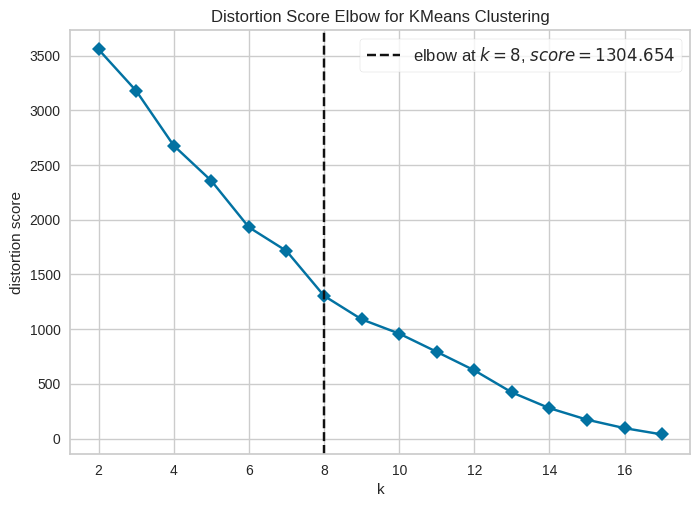

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow method
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(
    clustering, k=(2, 18), metric='distortion', timings=False, random_state=42
)

visualizer.fit(color_matrix_normalized)
visualizer.show()

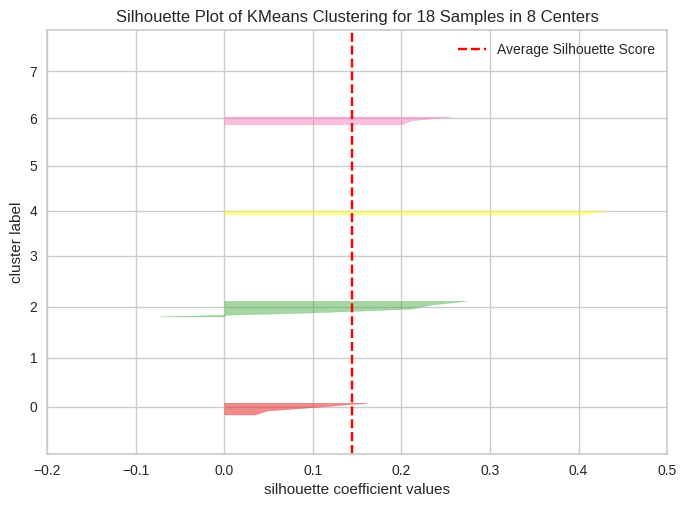

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 18 Samples in 8 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
# Alter this cell to change the number of clusters
n_clusters_colors = 8

# Silhouette plot
kmeans_model = KMeans(n_clusters_colors, random_state=42)
visualizer = SilhouetteVisualizer(kmeans_model, timings=False)

visualizer.fit(color_matrix_normalized)
visualizer.show()

### 3.3 KModes Clustering Results

K selected via elbow and silhouette above. KModes used for actual clustering since it uses hamming distance on binary data.

In [ ]:
# Gemini: "in M2 we standardized before clustering:
#   sc = StandardScaler()
#   normalized = sc.fit_transform(color_matrix)
#   kmeans.fit_predict(normalized)
#   do we still do that for KModes? our matrix is already 0s and 1s, scaling it
#   turns them into weird floats like -0.89 and 1.12 which doesnt seem right for hamming distance"
#   -> correct, dont scale. hamming counts exact mismatches between 0/1 values,
#   standardizing destroys that. pass the raw int matrix directly
# KModes on raw binary data (no scaler needed here)
km = KModes(n_clusters=n_clusters_colors, init='Huang', n_init=5, random_state=42)
color_matrix['cluster_labels'] = km.fit_predict(color_matrix).astype(str)

print(color_matrix['cluster_labels'].value_counts())

for label in sorted(color_matrix['cluster_labels'].unique()):
    colors_in = color_matrix[color_matrix['cluster_labels'] == label].index.tolist()
    print(f"\nCluster {label}:")
    for c in colors_in:
        print(f"  {c}: {round(df[c].mean()*100, 1)}%")

cluster_labels
2    4
4    4
6    3
5    2
1    2
0    1
3    1
7    1
Name: count, dtype: int64

Cluster 0:
  Bright_Red: 79.7%

Cluster 1:
  Dark_Sienna: 72.0%
  Midnight_Black: 78.7%

Cluster 2:
  Black_Gesso: 25.1%
  Indian_Red: 0.2%
  Liquid_Black: 3.5%
  Liquid_Clear: 12.7%

Cluster 3:
  Phthalo_Blue: 80.1%

Cluster 4:
  Cadmium_Yellow: 85.9%
  Indian_Yellow: 72.5%
  Sap_Green: 75.9%
  Yellow_Ochre: 81.1%

Cluster 5:
  Burnt_Umber: 13.6%
  Phthalo_Green: 28.8%

Cluster 6:
  Titanium_White: 99.3%
  Van_Dyke_Brown: 92.1%
  Alizarin_Crimson: 94.3%

Cluster 7:
  Prussian_Blue: 65.3%


### 3.4 PCA

PCA on paintings × colors to find which colors drive the most variance. StandardScaler is appropriate here since PCA decomposes variance.

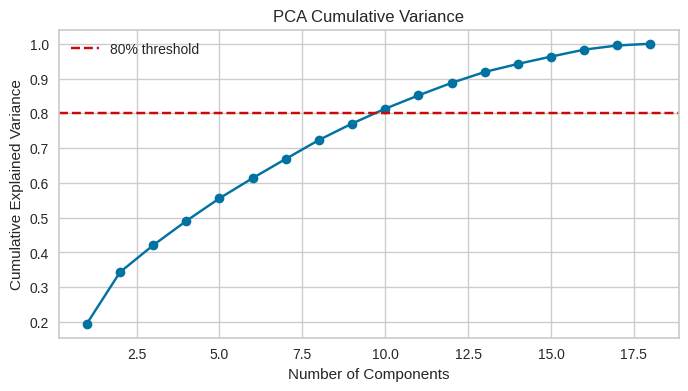

Components for 80% variance: 10


In [ ]:
# PCA on paintings x colors (normalized)
color_data = df[color_cols].astype(int)

sc_pca = StandardScaler()
color_data_normalized = pd.DataFrame(
    sc_pca.fit_transform(color_data),
    columns=color_cols
)

# Fit PCA
model = PCA()
model.fit(color_data_normalized)

# Scree plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(range(1, len(model.explained_variance_ratio_)+1),
        np.cumsum(model.explained_variance_ratio_), marker='o')
ax.axhline(y=0.8, color='r', linestyle='--', label='80% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Explained Variance')
ax.set_title('PCA Cumulative Variance')
ax.legend()
plt.show()

print(f"Components for 80% variance: {np.argmax(np.cumsum(model.explained_variance_ratio_) >= 0.8) + 1}")

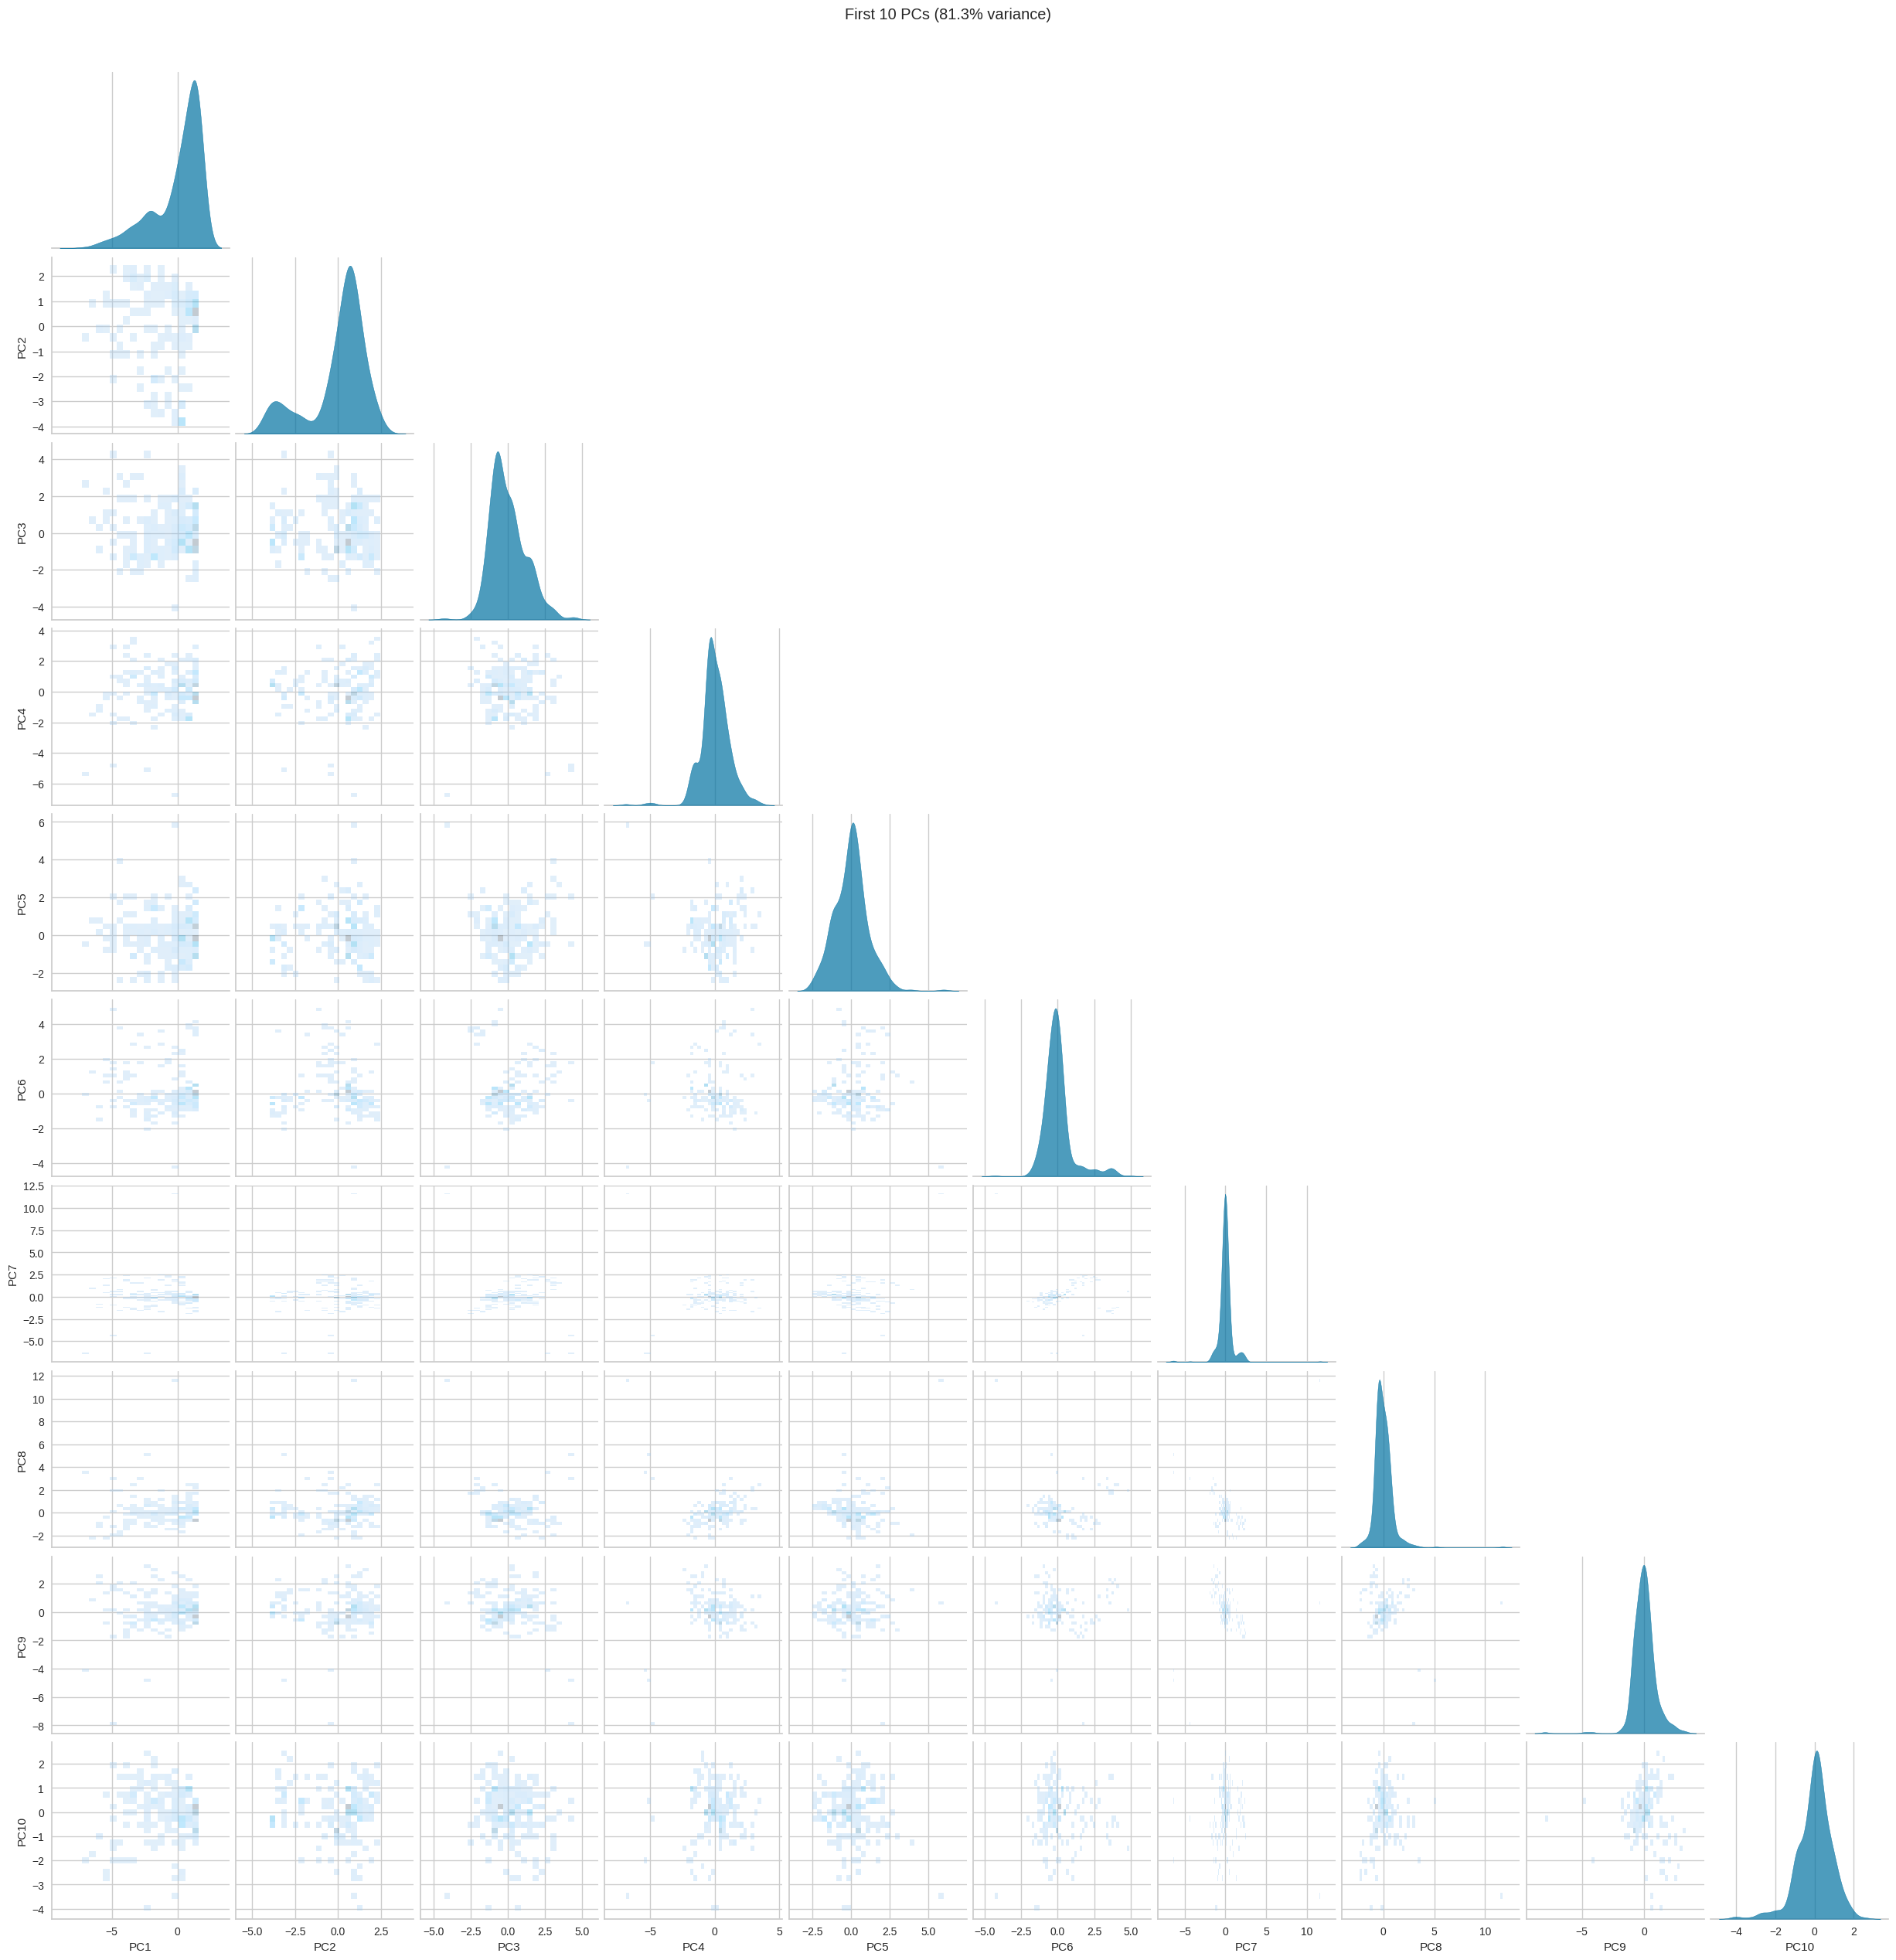

In [ ]:
transformed = model.transform(color_data_normalized)

n_pcs = 10
pc_cols = [f'PC{j+1}' for j in range(n_pcs)]
pca_df = pd.DataFrame(transformed[:, :n_pcs], columns=pc_cols)

sns.pairplot(pca_df, kind='hist', diag_kind='kde', corner=True,
    plot_kws={'alpha': 0.3},
    diag_kws={'alpha': 0.7}
)
plt.suptitle(f'First {n_pcs} PCs ({round(np.cumsum(model.explained_variance_ratio_)[:n_pcs][-1]*100, 1)}% variance)', y=1.02)
plt.show()

PC1 shows a visible bimodal split which probably captures the early vs late era shift. Synergy 1 tests this directly.

---

## Part 4: Palette Clustering (Jesse)

Clustering paintings (not colors) by their full 18-color profile. Can we find distinct palette types?

### 4.1 Normalize & Elbow

In [ ]:
palette_df = df[color_cols]

scaler = StandardScaler()
palette_scaled = scaler.fit_transform(palette_df)

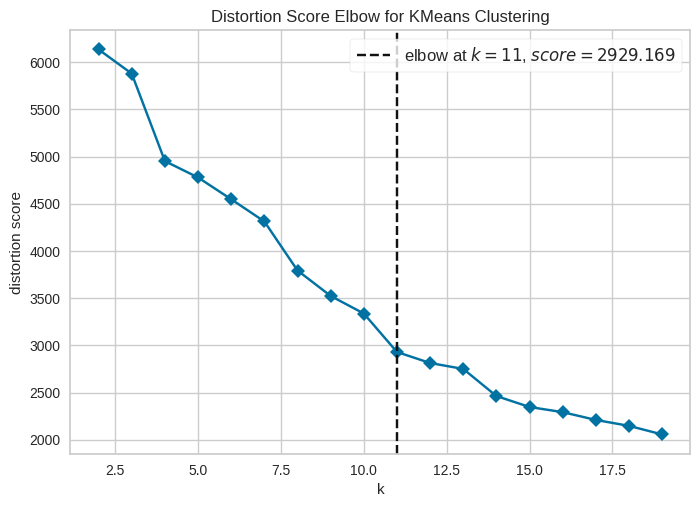

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
clustering = KMeans(random_state=42)
visualizer = KElbowVisualizer(clustering, k=(2, 20), metric='distortion', timings=False, random_state=42)

visualizer.fit(palette_scaled)
visualizer.show()

In [ ]:
#Alter this cell to change the amount of clusters based on the Elbow output
elbow_clusters = 11

### 4.2 KModes Clustering Results

KModes applied directly on binary data with K from the elbow plot. Fixes M2 issue of mixing KMeans elbow with hierarchical fcluster.

In [ ]:
# Gemini: "jesse's M2 did this:
#   Z = linkage(palette_scaled, method='ward')
#   elbow_clusters = 11  # from KMeans KElbowVisualizer
#   df['cluster'] = fcluster(Z, t=elbow_clusters, criterion='maxclust')
#   so the K came from a KMeans elbow but then got passed to fcluster which cuts a
#   dendrogram. that seems like two different algorithms? is this valid or is it a bug?"
#   -> thats a bug. KMeans elbow finds K assuming euclidean centroids. fcluster cuts a
#   hierarchical linkage tree which merges by a different criterion (ward variance).
#   the optimal K for one is not necessarily optimal for the other. use KModes.fit_predict()
# KModes replaces fcluster for actual clustering
km = KModes(n_clusters=elbow_clusters, init='Huang', n_init=5, random_state=42)
df['palette_cluster_km'] = km.fit_predict(palette_df.astype(int)).astype(str)

print("KModes cluster sizes:")
print(df['palette_cluster_km'].value_counts().sort_index())

KModes cluster sizes:
palette_cluster_km
0     32
1     79
10    51
2     44
3     21
4     31
5     50
6     27
7     33
8     23
9     12
Name: count, dtype: int64


---

## Part 5: Color Substitution Rules (Adam)

Association rule mining to find which colors co-occur and which ones avoid each other.

### 5.1 Association Rules

In [ ]:
df_basket = df[color_cols].copy()

frequent_itemsets = apriori(df_basket, min_support=0.03, use_colnames=True)
frequent_itemsets.sort_values(by="support", ascending=False)

,support,itemsets
13,0.992556,(Titanium_White)
16,0.942928,(Alizarin_Crimson)
132,0.937965,"(Titanium_White, Alizarin_Crimson)"
14,0.920596,(Van_Dyke_Brown)
130,0.915633,"(Titanium_White, Van_Dyke_Brown)"
...,...,...
10169,0.032258,"(Phthalo_Green, Titanium_White, Alizarin_Crims..."
6096,0.032258,"(Dark_Sienna, Phthalo_Green, Van_Dyke_Brown, M..."
6169,0.032258,"(Indian_Yellow, Liquid_Clear, Prussian_Blue, M..."
6112,0.032258,"(Dark_Sienna, Phthalo_Green, Titanium_White, V..."


In [ ]:
# Association rules
rules = association_rules(
    frequent_itemsets,
    num_itemsets=frequent_itemsets.shape[0],
    metric="confidence", min_threshold=0.3
)

# Strong co-occurrence rules
rules_filtered = rules[
    (rules['confidence'] > 0.8) &
    (rules['lift'] > 1.0) &
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
]
rules_filtered.sort_values(by=["confidence", "lift"], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
112,(Liquid_Black),(Alizarin_Crimson),0.034739,0.942928,0.034739,1.000000,1.060526,1.0,0.001983,inf,0.059126,0.036842,1.000000,0.518421
85,(Dark_Sienna),(Titanium_White),0.719603,0.992556,0.719603,1.000000,1.007500,1.0,0.005357,inf,0.026549,0.725000,1.000000,0.862500
110,(Liquid_Black),(Titanium_White),0.034739,0.992556,0.034739,1.000000,1.007500,1.0,0.000259,inf,0.007712,0.035000,1.000000,0.517500
117,(Liquid_Clear),(Titanium_White),0.126551,0.992556,0.126551,1.000000,1.007500,1.0,0.000942,inf,0.008523,0.127500,1.000000,0.563750
143,(Phthalo_Blue),(Titanium_White),0.801489,0.992556,0.801489,1.000000,1.007500,1.0,0.005966,inf,0.037500,0.807500,1.000000,0.903750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,(Van_Dyke_Brown),(Phthalo_Blue),0.920596,0.801489,0.749380,0.814016,1.015630,1.0,0.011533,1.067357,0.193812,0.770408,0.063106,0.874500
22,(Midnight_Black),(Bright_Red),0.786600,0.796526,0.640199,0.813880,1.021787,1.0,0.013651,1.093241,0.099919,0.678947,0.085289,0.808809
11,(Black_Gesso),(Yellow_Ochre),0.250620,0.811414,0.203474,0.811881,1.000575,1.0,0.000117,1.002481,0.000767,0.236994,0.002475,0.531323
142,(Titanium_White),(Phthalo_Blue),0.992556,0.801489,0.801489,0.807500,1.007500,1.0,0.005966,1.031227,1.000000,0.807500,0.030281,0.903750


### 5.2 Exclusion Rules

When lift < 1, two colors show up together less often than expected by chance. The strongest exclusion pairs by lowest lift involve Phthalo Green, not the era-shift trio. The Burnt Umber / Dark Sienna + Midnight Black relationship is a temporal shift that shows up in the clustering and era analysis, not in the pairwise lift stats. We keep these as separate findings below.

In [ ]:
# Filter for exclusion patterns: lift < 1 means colors co-occur LESS than expected
exclusion_rules = rules[
    (rules['lift'] < 1.0) &
    (rules['antecedents'].apply(len) == 1) &
    (rules['consequents'].apply(len) == 1)
].sort_values('lift')

print(f"Exclusion rules (lift < 1): {len(exclusion_rules)}")
exclusion_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15)

Exclusion rules (lift < 1): 31


,antecedents,consequents,support,confidence,lift
123,(Phthalo_Green),(Midnight_Black),0.163772,0.568966,0.723322
79,(Phthalo_Green),(Dark_Sienna),0.153846,0.534483,0.742747
20,(Liquid_Clear),(Bright_Red),0.086849,0.686275,0.861585
7,(Black_Gesso),(Prussian_Blue),0.141439,0.564356,0.864774
116,(Liquid_Clear),(Sap_Green),0.084367,0.666667,0.877996
118,(Liquid_Clear),(Van_Dyke_Brown),0.109181,0.862745,0.937160
138,(Prussian_Blue),(Phthalo_Blue),0.493797,0.756654,0.944061
139,(Phthalo_Blue),(Prussian_Blue),0.493797,0.616099,0.944061
92,(Liquid_Clear),(Indian_Yellow),0.086849,0.686275,0.947153
43,(Burnt_Umber),(Prussian_Blue),0.084367,0.618182,0.947252


In [ ]:
# Gemini: "my exclusion_rules df has both directions for each pair, eg:
#   Phthalo_Green -> Dark_Sienna  lift=0.743
#   Dark_Sienna -> Phthalo_Green  lift=0.743
#   i only want each pair once. my idea is something like:
#   seen = set()
#   for row in rules: pair = sort(antecedent, consequent); if pair not in seen: keep it
#   but the antecedents column is a frozenset not a string, how do i pull the name out?"
#   -> list(row['antecedents'])[0] extracts the string. then tuple(sorted([ant, con]))
#   gives you a hashable key for the set
# Derive top exclusion pairs from lowest-lift rules
# Deduplicate: keep each pair once (A->B and B->A are the same pair)
seen_pairs = set()
top_exclusion_pairs = []
for _, row in exclusion_rules.iterrows():
    ant = list(row['antecedents'])[0]
    con = list(row['consequents'])[0]
    pair_key = tuple(sorted([ant, con]))
    if pair_key not in seen_pairs:
        seen_pairs.add(pair_key)
        top_exclusion_pairs.append({'color_a': ant, 'color_b': con, 'lift': row['lift']})

top_exclusion_pairs = pd.DataFrame(top_exclusion_pairs).head(10)
print("Top 10 exclusion pairs (deduplicated, by lowest lift):")
print(top_exclusion_pairs.to_string(index=False))

Top 10 exclusion pairs (deduplicated, by lowest lift):
      color_a        color_b     lift
Phthalo_Green Midnight_Black 0.723322
Phthalo_Green    Dark_Sienna 0.742747
 Liquid_Clear     Bright_Red 0.861585
  Black_Gesso  Prussian_Blue 0.864774
 Liquid_Clear      Sap_Green 0.877996
 Liquid_Clear Van_Dyke_Brown 0.937160
Prussian_Blue   Phthalo_Blue 0.944061
 Liquid_Clear  Indian_Yellow 0.947153
  Burnt_Umber  Prussian_Blue 0.947252
Prussian_Blue   Yellow_Ochre 0.965314


### 5.3 Era Shift Colors

Colors with the biggest usage change between early (S1-10) and late (S21-31) eras. Renamed from `sub_colors` since this is a permanent era shift, not a per-painting substitution.

In [ ]:
era_shift_colors = ['Dark_Sienna', 'Midnight_Black', 'Burnt_Umber']

early_df = df[df['season'] <= 10]
late_df = df[df['season'] >= 21]

print(f"Early (S1-10): {len(early_df)} paintings    Late (S21-31): {len(late_df)} paintings")
print(f"\n{'Color':<20s} {'Early':>8s} {'Late':>8s}")
print("-" * 40)
for c in era_shift_colors:
    print(f"  {c:<20s} {early_df[c].mean():>6.1%}   {late_df[c].mean():>6.1%}")

Early (S1-10): 130 paintings    Late (S21-31): 143 paintings

Color                   Early     Late
----------------------------------------
  Dark_Sienna           36.2%    81.1%
  Midnight_Black        37.7%    97.9%
  Burnt_Umber           42.3%     0.0%


---

## Part 6: Integration & Synergy

Experiments connecting our three M2 analyses.

---

---

### Synergy 1: PCA Colored by Era

Q1 (Anton) noticed a bimodal split in PC1 and suspected it was the era shift. Q3 (Adam) proved the shift happens around season 7. Here we color the PCA scatter by era to confirm.

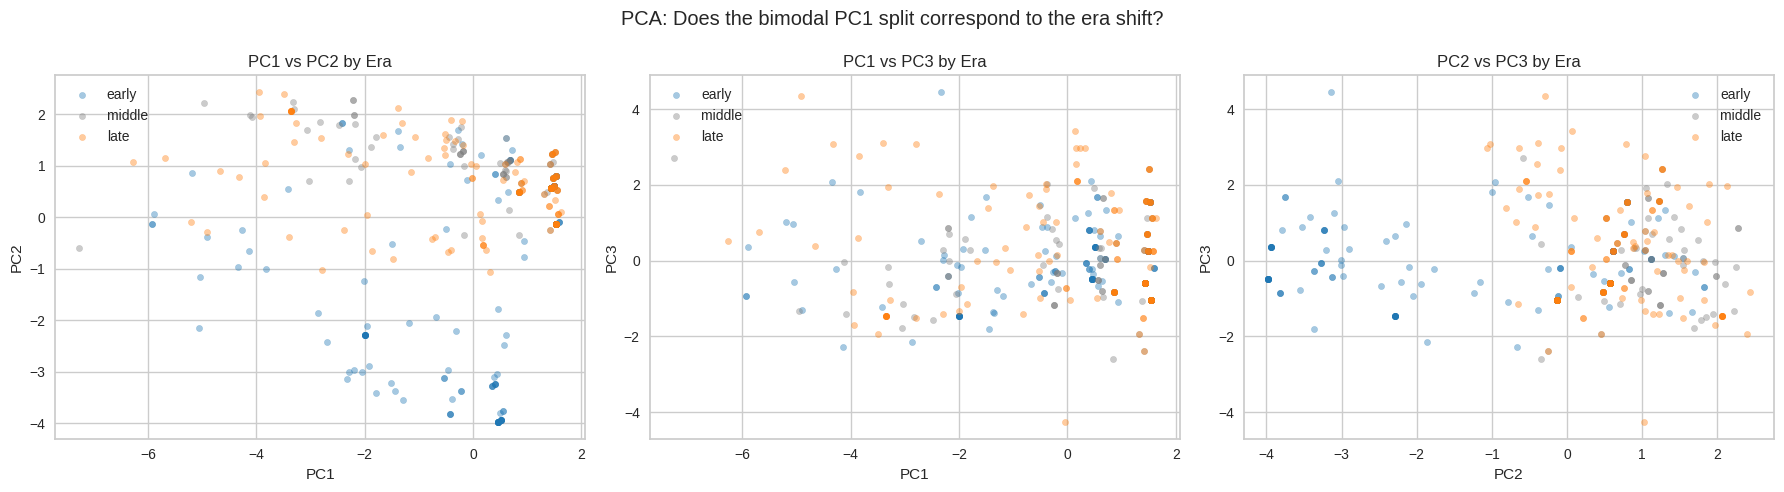

In [ ]:
# Gemini: "i want 3 scatter plots next to each other: PC1vPC2, PC1vPC3, PC2vPC3.
#   each point colored by era. i have pca_df with columns PC1..PC10 and an era column.
#   i tried:
#     for combo in [(PC1,PC2), (PC1,PC3), (PC2,PC3)]:
#       plt.subplot(1,3,i)
#       for each era: plt.scatter(filtered)
#   but the subplots keep overwriting each other and the legend shows up 3 times"
#   -> use fig, axes = plt.subplots(1,3). then axes[i].scatter() targets each subplot.
#   put the legend call inside the loop so each panel gets its own
# PCA colored by era
pca_df['era'] = df['era'].values

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
era_colors = {'early': 'tab:blue', 'middle': 'tab:gray', 'late': 'tab:orange'}

for i, (pc_x, pc_y) in enumerate([('PC1', 'PC2'), ('PC1', 'PC3'), ('PC2', 'PC3')]):
    for era_label, color in era_colors.items():
        mask = pca_df['era'] == era_label
        axes[i].scatter(pca_df.loc[mask, pc_x], pca_df.loc[mask, pc_y],
                       c=color, alpha=0.4, label=era_label, s=20)
    axes[i].set_xlabel(pc_x)
    axes[i].set_ylabel(pc_y)
    axes[i].legend()
    axes[i].set_title(f'{pc_x} vs {pc_y} by Era')

plt.suptitle('PCA: Does the bimodal PC split correspond to the era shift?')
plt.tight_layout()
plt.show()

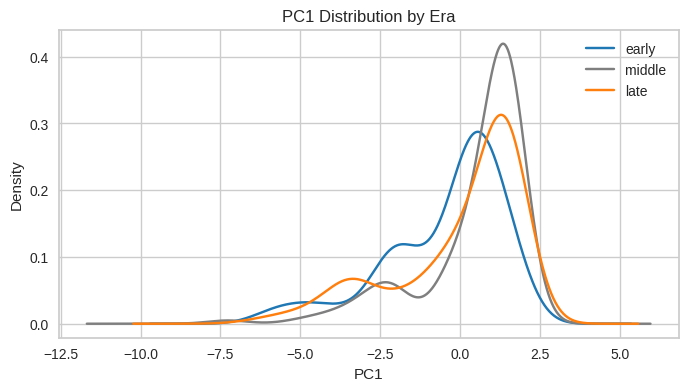

In [ ]:
# PC1 distribution by era
fig, ax = plt.subplots(figsize=(8, 4))
for era_label, color in era_colors.items():
    mask = pca_df['era'] == era_label
    pca_df.loc[mask, 'PC1'].plot.kde(ax=ax, label=era_label, color=color)
ax.set_title('PC1 Distribution by Era')
ax.set_xlabel('PC1')
ax.legend()
plt.show()

---

### Synergy 2: Palette Clusters Checked Against Era

Q2 (Jesse) found palette clusters don't align well with themes. Q3 (Adam) found the era shift is the dominant signal. Do the palette clusters actually just capture the era?

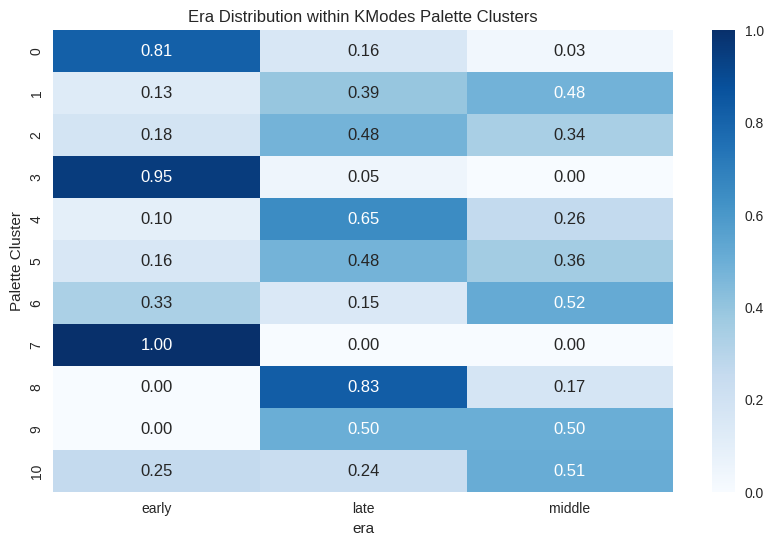


Era composition per cluster:
  Cluster 0 ( 32 paintings): early 81%, middle 3%, late 16%
  Cluster 1 ( 79 paintings): early 13%, middle 48%, late 39%
  Cluster 2 ( 44 paintings): early 18%, middle 34%, late 48%
  Cluster 3 ( 21 paintings): early 95%, middle 0%, late 5%
  Cluster 4 ( 31 paintings): early 10%, middle 26%, late 65%
  Cluster 5 ( 50 paintings): early 16%, middle 36%, late 48%
  Cluster 6 ( 27 paintings): early 33%, middle 52%, late 15%
  Cluster 7 ( 33 paintings): early 100%, middle 0%, late 0%
  Cluster 8 ( 23 paintings): early 0%, middle 17%, late 83%
  Cluster 9 ( 12 paintings): early 0%, middle 50%, late 50%
  Cluster 10 ( 51 paintings): early 25%, middle 51%, late 24%


In [ ]:
# Gemini: "i made a crosstab: pd.crosstab(df['palette_cluster_km'], df['era'], normalize='index')
#   and the heatmap looks right but the y-axis goes 0, 1, 10, 2, 3... instead of 0-10.
#   i think its sorting alphabetically as strings? the column was set to str earlier for
#   value_counts. do i just .astype(int) before the crosstab?"
#   -> yes exactly, cast to int first and the crosstab will sort numerically
# Cross-tab palette clusters with era

# Converted the 'palette_cluster_km' to integer otherwise it's prints the columns as 0, 1, 10, 2, ... rather than 0, 1, 2, 3, ... due to 'palette_cluster_km' being a series of strings
df['palette_cluster_km'] = df['palette_cluster_km'].astype(int)

era_by_cluster = pd.crosstab(df['palette_cluster_km'], df['era'], normalize='index')
plt.figure(figsize=(10, 6))
sns.heatmap(era_by_cluster, annot=True, cmap='Blues', fmt='.2f')
plt.title("Era Distribution within KModes Palette Clusters")
plt.ylabel('Palette Cluster')
plt.show()

print("\nEra composition per cluster:")
for cl in sorted(df['palette_cluster_km'].unique()):
    subset = df[df['palette_cluster_km'] == cl]
    early_pct = (subset['era'] == 'early').mean()
    late_pct = (subset['era'] == 'late').mean()
    mid_pct = 1 - early_pct - late_pct
    print(f"  Cluster {cl} ({len(subset):>3d} paintings): "
          f"early {early_pct:.0%}, middle {mid_pct:.0%}, late {late_pct:.0%}")

---

### Synergy 3: Exclusion Rules vs Color Clusters

Q3 (Adam) found pairs of colors that avoid each other (lift < 1). Q1 (Anton) grouped colors into clusters based on co-occurrence. If both methods capture real structure, exclusion pairs should be in DIFFERENT clusters and co-occurring pairs should be in the SAME cluster.

In [ ]:
# Gemini: "i want to cross-validate adam's exclusion pairs against anton's color clusters.
#   logic: if two colors have lift < 1 (they avoid each other), they should be in different clusters.
#   color_matrix has a 'cluster_labels' column. i need a lookup like:
#     for pair in top_exclusion_pairs:
#       cl_a = lookup[pair.color_a]
#       cl_b = lookup[pair.color_b]
#       print SAME if cl_a == cl_b else DIFF
#   whats the cleanest way to build that lookup dict from the dataframe?"
#   -> color_matrix['cluster_labels'].to_dict() maps index (color name) to cluster label directly
# Exclusion pairs and co-occurrence pairs vs cluster assignments
color_to_cluster = color_matrix['cluster_labels'].to_dict()

print("Top exclusion pairs vs cluster assignments:")
print("(If methods agree, exclusion pairs should land in DIFFERENT clusters)")
for _, row in top_exclusion_pairs.iterrows():
    ant = row['color_a']
    con = row['color_b']
    ant_cl = color_to_cluster.get(ant, '?')
    con_cl = color_to_cluster.get(con, '?')
    same = "SAME" if ant_cl == con_cl else "DIFF"
    print(f"  {ant:<20s} (cl {ant_cl}) <-> {con:<20s} (cl {con_cl}): "
          f"{same}  lift={row['lift']:.3f}")

print("\nTop co-occurrence pairs vs cluster assignments:")
print("(If methods agree, co-occurring pairs should land in SAME clusters)")
for _, row in rules_filtered.head(10).iterrows():
    ant = list(row['antecedents'])[0]
    con = list(row['consequents'])[0]
    ant_cl = color_to_cluster.get(ant, '?')
    con_cl = color_to_cluster.get(con, '?')
    same = "SAME" if ant_cl == con_cl else "DIFF"
    print(f"  {ant:<20s} (cl {ant_cl}) -> {con:<20s} (cl {con_cl}): "
          f"{same}  lift={row['lift']:.3f}")

Top exclusion pairs vs cluster assignments:
(If methods agree, exclusion pairs should land in DIFFERENT clusters)
  Phthalo_Green        (cl 5) <-> Midnight_Black       (cl 1): DIFF  lift=0.723
  Phthalo_Green        (cl 5) <-> Dark_Sienna          (cl 1): DIFF  lift=0.743
  Liquid_Clear         (cl 2) <-> Bright_Red           (cl 0): DIFF  lift=0.862
  Black_Gesso          (cl 2) <-> Prussian_Blue        (cl 7): DIFF  lift=0.865
  Liquid_Clear         (cl 2) <-> Sap_Green            (cl 4): DIFF  lift=0.878
  Liquid_Clear         (cl 2) <-> Van_Dyke_Brown       (cl 6): DIFF  lift=0.937
  Prussian_Blue        (cl 7) <-> Phthalo_Blue         (cl 3): DIFF  lift=0.944
  Liquid_Clear         (cl 2) <-> Indian_Yellow        (cl 4): DIFF  lift=0.947
  Burnt_Umber          (cl 5) <-> Prussian_Blue        (cl 7): DIFF  lift=0.947
  Prussian_Blue        (cl 7) <-> Yellow_Ochre         (cl 4): DIFF  lift=0.965

Top co-occurrence pairs vs cluster assignments:
(If methods agree, co-occurring pairs

## Part 7: Summary & Code Attribution

**Key integration findings:**

1. **Synergy 1:** PCA bimodal split in PC1 confirmed as era-driven
2. **Synergy 2:** Palette clusters are largely era-homogeneous, explaining the weak theme alignment from M2
3. **Synergy 3:** Exclusion pairs from association rules land in different color clusters

**M2 Feedback addressed:** KMeans replaced with KModes for all clustering on binary data. KElbowVisualizer kept for K selection, KModes used for actual cluster assignment.

---

### Use of Generative AI Tools

**Google Gemini (Integrated in Google Colab)**

Gemini was used as a coding assistant and technical reference throughout the M3 integration work. The main areas where we relied on it were: understanding when and why to switch from KMeans to KModes for binary data (and confirming we should skip the StandardScaler step), debugging Jesse's M2 fcluster issue where KMeans K was being applied to a hierarchical linkage output, and working through the logic for several synergy experiments that had no direct M2 equivalent, particularly the exclusion pair deduplication and the cluster lookup for era comparisons. Prompts and responses are documented inline in the code cells throughout the notebook. All suggestions were reviewed and tested before use.